# Grade: /20 Mark(s)

# Assignment 03: Confidence Intervals & The Bootstrap

Once you are finished, ensure to complete the following steps.

1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline.



In [1]:
#It's dangerous to go alone.  Take these
import numpy as np
from scipy.stats import t, sem
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import pandas as pd
import seaborn as sns

### Question 1: /2 Mark(s)


Recall from lecture that a $100(1-\alpha)\%$ confidence interval for the mean is 

$$ \bar{x} \pm  t_{1-\alpha/2, n-1} \dfrac{\hat{\sigma}}{\sqrt{n}} $$

Where $ t_{1-\alpha/2, n-1}$ is the appropiorate quantile of a Student's t distribution with $n-1$ degrees of freedom.  

Write a function called `confidence_interval` which takes as it's argument an array of data called `data` and returns two things:

* An estimated mean of `data`, and 

* The lower and upper bounds of the 95% confidence interval for the mean of `data`.  Ensure these are returned in a numpy array of shape (2,)

To get the appropirate quantiles for the t-distribution, you can use `scipy.stats.t`, which implements some statistical functions for the t-distribution.  Take a look at the documentation for `scipy.stats.t`, especially the `ppf` method.

Here is the documentation: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.t.html





In [2]:
def confidence_interval(data):

    n = data.size
    t_quantile = t.ppf(1-0.05/2, df=n-1)
    estimated_mean = data.mean()
    # Note, np.std divides by n and not n-1
    # Force it to apply the correct formula by ussing ddof=1
    # Alternaively, you can use scipy.stats.sem to compute
    #The standard error
    estimated_se = data.std(ddof=1)/np.sqrt(data.size)
    bounds = estimated_mean + t_quantile*estimated_se*np.array([-1,1])

    
    return estimated_mean, bounds

### Question 2: /2 Mark(s)

The "95% confidence interval" is named so because the long term relative frequency of these estimators containing the true estimand is 95%.  That is to say **if I construct 100 95% confidence intervals for the sample mean again and again from the same data generating mechanism, 95 of these intervals I construct will contain the true population mean**.

Write a function called `ci_simulation` that runs some simulations to show this is the case.  From a standard normal distirbution, sample 25 observations and construct a confidence interval.  Do this 20 times and plot the intervals using `matplotlib.pyplot.errorbar`.  Color the bar red if the confidence interval does not caputre the true mean and blue if it does.  If you are unfamilliar with `matplotlib.pyplot.errorbar`, I highly suggest reading Matplotlib's excellent documentation which has some examples at the bottom of the webpage.

If you are unfamilliar with how to sample random numbers, I suggest you look at `numpy.random.normal`.  Try searching for the documentation for that function yourself if you need to.

Here is the documentation for `matplotlib.pyplot.errorbar`: https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.errorbar.html

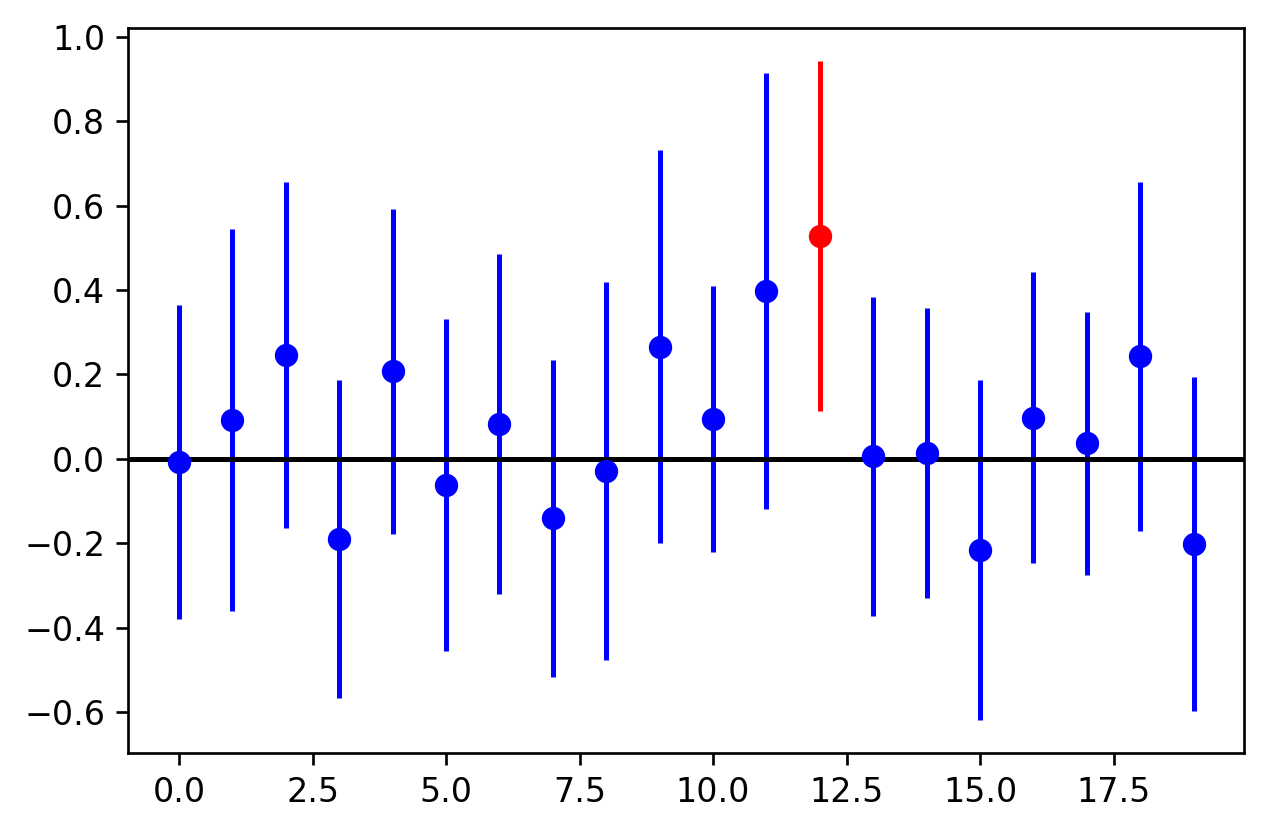

In [3]:
def ci_simulation():
    # Set the random seed to always get the same random numbers. 
    # This is for Reproducibility. 
    np.random.seed(4)
    
    # Create the figure.
    fig, ax = plt.subplots(dpi = 120)

    # If the interval crosses this line, it should be blue, else red.
    ax.axhline(0, color = 'k')

    # Do the following 20 times
    for i in range(20):

        #Draw 25 observations from a standard normal
        data = np.random.normal(size = 25)
        # Compute what we need for the CI, namely the mean and the bounds
        mu,bounds = confidence_interval(data)
        
        # color should be blue if it crosses the black line
        color = 'blue'
        if (min(bounds)>0)|(max(bounds)<0):
            # but in the case it does not, turn it red
            color = 'red'

        # Need to get the length of the interval from bounds
        interval_len = 1.0/2*(bounds[1] - bounds[0])

        ax.errorbar(i, mu, yerr=interval_len, color = color, fmt = 'o')

    # This function does not have to return anything
    return None

ci_simulation()

### Question 3: /2 Mark(s)

If you haven't changed the random seed from 4 and if you implemented the solution correctly, you should one red interval.

Answer the following below in no more than 2 sentences:

a) How many red intervals did we expect to see?  What is your justifiation for this?

Write your answers below

Note:  Changing the random seed might affect how many red intervals you see.  Try changing the  random seed in your function to 3.  This will yield two red intervals (which is different than what you should expect to see).  This happends because of random sampling error.  Probability is a funny thing.  It doesn't guarentee that out of *every* 50 intervals constructed 45 will contain the mean.

---


a) We expected 1 interval. 5% of 20 is 1.



### Question 4: /2 Mark(s)

Load in the `hockey_draftees_2005.csv` data into pandas. It contains data from hockey players drafted in 2005. 
Fit a linear model of weight (`wt`) explained by height (`ht`) using statsmodels' formula api for linear regression. Call your fitted model `model`.  
Make a scatter plot of the height (x-axis) against weight (y-axis). 
Add the predicted values for 66-80 inches. 

Print out the r squared for this model.

Training rsquared is  0.43807746842392203


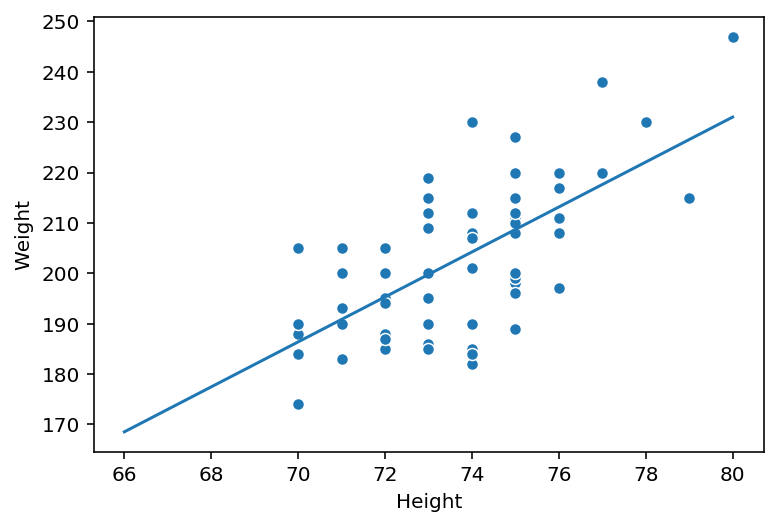

In [4]:
df=pd.read_csv('hockey_draftees_2005.csv')

# Make it and fit the model 
model = sm.ols('wt ~ ht', data = df).fit()

# Make the scatter plot 
ax=sns.scatterplot(x=df.ht,y=df.wt)
ax.set_xlabel('Height')
ax.set_ylabel('Weight')

#Generate and plot the predicted values
xp = np.linspace(66, 80, 30)
yp = model.predict(exog=dict(ht=xp))
plt.plot(xp,yp)

print('Training rsquared is ',model.rsquared)

### Question 5:  /4 Mark(s): Bootstrap confidence intervals on parameters

How confident can we be about the relation between height and weight? 
To judge this we need confidence intervals let's use the bootstrap.

Write a function called `bootstrap` which takes three arguments:

* `data`, which is a dataframe having columns 'weight' and 'height'
* `model` which is a statsmodel ols model. `data` should look the the data `model` was trained on so that we can use `model` to make predictions on `data`.
* `numboot` which is an integer denoting how many bootstrap replications to perform.

Write `bootstrap` to perform bootstrap resampling. You can use `pd.DataFrame.sample` with `replace = True` to perform the resampling.  `bootstrap` should return:
params: a numpy array of size [numboot,numParams] of bootstraped parameter values. 
res   : a list of size numboot of the fitted models 

Here is the documentation for `pd.DataFrame.sample`: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html

Then call the function to get 1000 boostrap samples for the model 'wt~ht'. 
Make a joint scatter plot of the parameter value for the intercept and for the slope. 
Written answer: What do you notice? Why do you think the estimate for the intercept has such a high negative correlation with the slope? 

In [16]:
def bootstrap(data, formula, numboot):
    # Fit the model to the original data, just to get the number of params  
    model = sm.ols(formula,data=data).fit()
    numParams = model.params.size
    # Initialize parameter array to be 
    params = np.zeros((numboot,numParams))
    N = data.shape[0]
    res = []
    for i in range(numboot):
        df_bootstrapped = data.sample( N , replace = True)
        model = sm.ols(formula,data=df_bootstrapped).fit()
        params[i,:]=model.params.values
        res.append(model)
    return res,params



resB,params = bootstrap(df,'wt~ht',100)

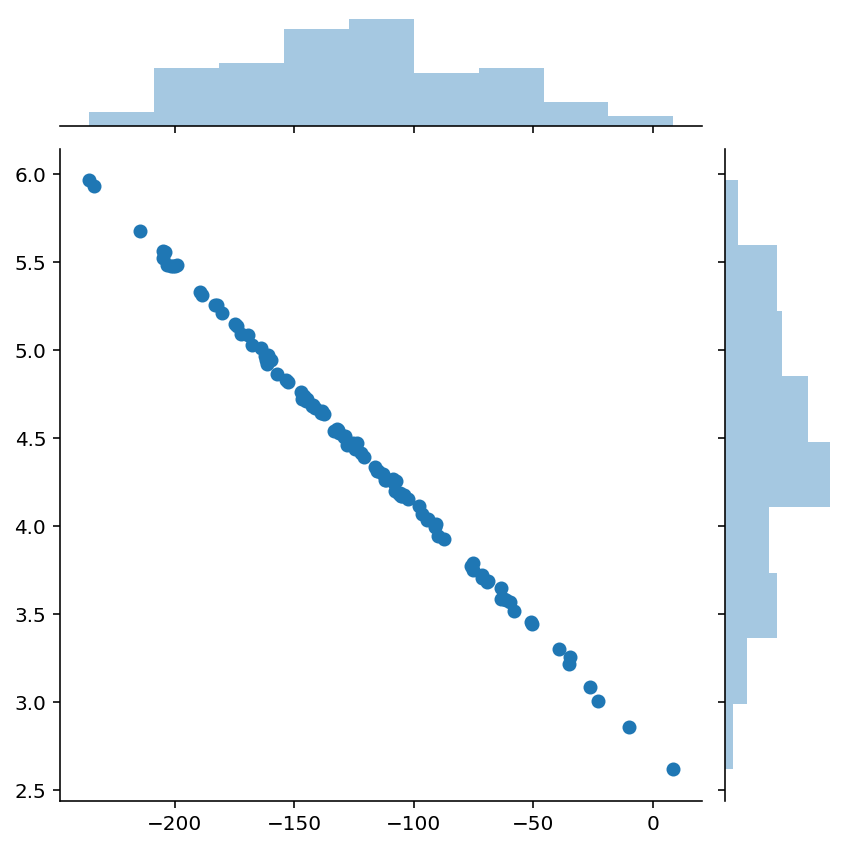

In [12]:
sns.jointplot(x=params[:,0],y=params[:,1])

### Question 6: /2 Mark(s)

Plot the bootstrap estimates for the slope as a histogram.  Use your samples to compute a 95% confidence interval. How can you interpret this confindence interval?  

My confidence interval is between 3.0431761655747978  and  5.622555122898742


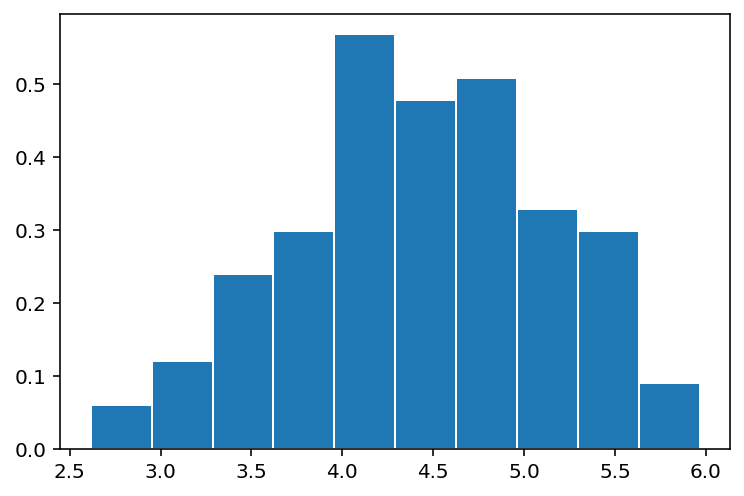

In [13]:
bs_replicates = params[:,1]
plt.hist(bs_replicates, edgecolor = 'white', density=True)
ci_lower, ci_upper = np.quantile(bs_replicates, [0.025, 0.975])

print('My confidence interval is between', ci_lower, ' and ', ci_upper)

### Question 7: /3 Mark(s)

Draw again a scatter plot of ht against weight 
Use the first 20 fitted bootstrap models to derive predictions for the height ranging from 60 to 88. Draw all these lines onto your scatter plot. 

Written answer: Where are we most uncertain in our prediction about the weight of a player? How does the negative correlation between slope and intercept play a role here?  Why is the spread of the prediction in the mean weight so much lower than the variability of our intercept parameter? 

Text(0, 0.5, 'Weight')

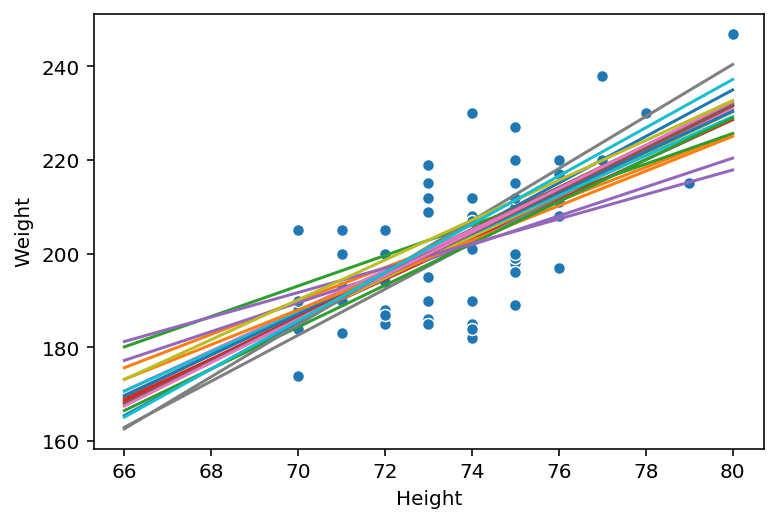

In [14]:
ax=sns.scatterplot(x=df.ht,y=df.wt)
xp = np.linspace(66, 80, 30)
for i in range(20):
    yp = resB[i].predict(exog=dict(ht=xp))
    plt.plot(xp,yp)

ax.set_xlabel('Height')
ax.set_ylabel('Weight')


The greatest uncertainty we have for the very small and very tall players. All lines agree in their prediction for the players of middle weight. For the lines to cross in the middle of the graph, a large slope needs to have a small intercept and a small slope needs to have a large intercept. 

### Question 8:  /3 Mark(s)

Now, let's see how well our model performs out of sample.  Load in the `hockey_draftees_test.csv` file into a dataframe.  
Use your fitted `model` to make predictions. 

Make a scatter plot of the test data and superimpose the prediction of the model. 
To evaluate this prediction, calculate the r-square value for the out of sample (oos) data.  Statsmodels doesn't provide a function to compute r-squared on new data.  You will have to write one yourself or find one that performs the computation for you.

Out of sample rsquared is  -0.015001136144208171


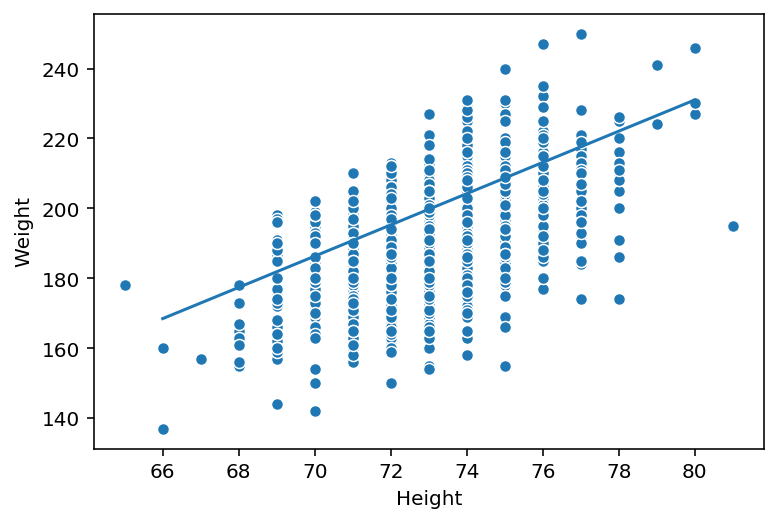

In [15]:
df_test=pd.read_csv('hockey_draftees_test.csv')

# Make the scatter plot 
ax=sns.scatterplot(x=df_test.ht,y=df_test.wt)
ax.set_xlabel('Height')
ax.set_ylabel('Weight')

#Generate and plot the predicted values
xp = np.linspace(66, 80, 30)
yp = model.predict(exog=dict(ht=xp))
plt.plot(xp,yp)

# Now do the prediction for the test data and compute R2
y = df_test.wt.values
yhat = model.predict(df_test).values
rsquared_oos = 1 - (np.sum(np.power(y - yhat,2)) / np.sum(np.power(y - y.mean(),2)))

print('Out of sample rsquared is ', rsquared_oos)


### Follow These Steps!
Once you are finished, ensure to complete the following steps.

1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline.